> ### Note on Labs and Assignments:
>
> 🔧 Look for the **wrench emoji** 🔧 — it highlights where you're expected to take action!
>
> These sections are graded and are not optional.
>

# IS 4487 Lab 13: Sentiment Analysis

## Outline

- Analyze a dataset utilizing sentiment
- Compare the VADER and TextBlob models
- Learn the basics of sentiment analysis

In this lab, you will explore **sentiment analysis** techniques to determine the positivity/negativity of certain sentences.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/lab_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Data Description

We will use a dataset containing movie reviews.  Each review is contained in the "Phrase" variable.  This dataset is pre-labeled with the Sentiment, but we will use tools to calculate our own Sentiment, which could then be compared to the pre-labeled values.  

The dataset does not specify the movie that it is reviewing.  We wouldn't be able to use this to calculate a movie score, like Rotten Tomatoes.  But we can observe the overall sentiment of reviewers and practice using the text analytics tools available in Python.

| Column                        | Data Type       | Description                                                  |
|------------------------------|------------------|--------------------------------------------------------------|
| `PhraseID`                   | Integer           | ID of an entry                                               |
| `SentenceID`                 | Integer           | Shows which phrases belong to which sentence                                      |
| `Phrase`             | String       | A sentence/phrase                       |
| `Sentiment`                 | Categorical       | 0 = Very Negative, 1 = Negative, 2 = Neutral, 3 = Positive, 4= Highly Positive        |

Source: https://www.kaggle.com/datasets/satwikdondapati/moviereviewsentimentalanalysis

## Part 1: Load and Prepare the Data

### What you are going to do:
- Load the dataset
- Preview the data

### Why this matters:
All throughout the semester you've mainly dealt with data that had a wide variety of types. But what if we only have a few variables and one of them has tons of data?

**Things to notice:**
- Which variables are actually important?
- Why are there so few variables? Which variable(s) has the most data?


### 🔧 Try It Yourself
Import the libraries and dataset

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/movie_reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Part 2 : See the Scores
### What you are going to do:
- count how many entries belong to each Sentiment score
- create a visualization of the value counts

### Why this matters:
In the dataset you'll notice that each phrase has a sentiment score. These scores tell us whether a phrase is positive or negative or neutral in tone. In later steps we will be predicting scores, so it is important to know if there is any skew of sentiment within the data.  

**Things to notice:**
- Why are there 5 total Sentiment scores?
- What does each score mean?
- What is the count of each score?

### 🔧 Try It Yourself — Part 2

1. create a variable that stores the ```value_counts``` of the Sentiment column
2. create a bar chart using the ```value_counts``` variable you just created

### In Your Response:
1. make a comment about the chart. Is there any skew within the data? Is it more positive, negative, or neutral? (Hint: refer to the data dictionary at the very top)

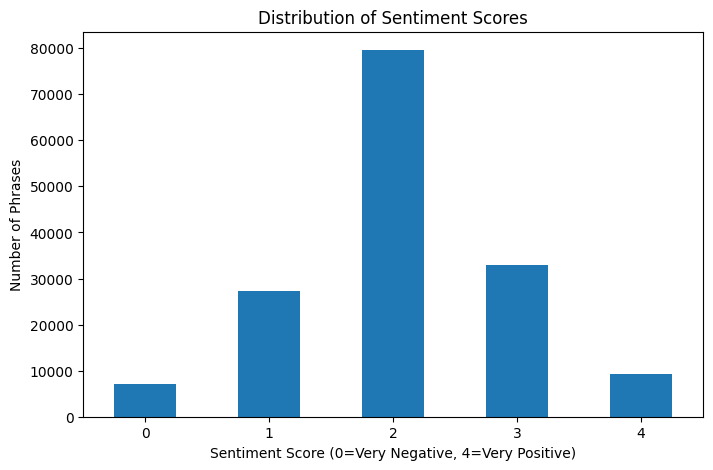

In [3]:
sentiment_counts = df['Sentiment'].value_counts().sort_index()
sentiment_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score (0=Very Negative, 4=Very Positive)')
plt.ylabel('Number of Phrases')
plt.xticks(rotation=0)
plt.show()

### ✍️ Your Response: 🔧
1. Based on the bar chart and the sentiment counts, the data is significantly skewed towards neutral sentiment (score 2). There are considerably more neutral phrases than any other sentiment category. The number of positive and negative phrases is lower, and very negative and highly positive phrases are the least frequent.

# Part 3: VADER
### What you are going to do:
- run and train a VADER model
- evaluate its performance

### Why this matters:
VADER is a rule based model great for handling short sentences and phrases. It works by looking at each word individually and assigning an individual score to it. These scores then get compounded at the end of its calculation and it generates a sentiment score. Since it looks at one word at a time it may struggle with longer sentences. So VADER is best suited for analyzing social media and reviews.

**Things to notice:**
- what does the score_to_label function do?

In [4]:
# set up and run the VADER model
sia = SentimentIntensityAnalyzer()

df["vader_score"] = [sia.polarity_scores(text)["compound"] for text in df["Phrase"]]

# there are a total of 5 sentiment scores but polarity only gives us scores between -1 to 1
# need to map the scores from the dataset so that polarity can use it
def score_to_label(score):
    if score <= -0.6:
        return 0  # very negative
    elif score <= -0.2:
        return 1  # somewhat negative
    elif score < 0.2:
        return 2  # neutral
    elif score < 0.6:
        return 3  # somewhat positive
    else:
        return 4  # very positive

df["vader_pred"] = df["vader_score"].apply(score_to_label)

# View the predicted score
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,vader_score,vader_pred
0,1,1,A series of escapades demonstrating the adage ...,1,0.5579,3
1,2,1,A series of escapades demonstrating the adage ...,2,0.4404,3
2,3,1,A series,2,0.0000,2
3,4,1,A,2,0.0000,2
4,5,1,series,2,0.0000,2


### 🔧 Try It Yourself — Part 3
Now we know if the data is positively, negatively, or neutrally skewed. For the next two steps we are going to be testing out 2 new models and comparing their results.
1. using ```vader_pred``` and ```Sentiment``` generate a classification report
2. using ```vader_pred``` and ```Sentiment``` generate a confusion matrix

### In Your Response:
1. make a comment. Why are the values for a sentiment score of 2 much higher than all the others?

In [5]:
print('VADER Classification Report:')
print(classification_report(df['Sentiment'], df['vader_pred']))

print('\nVADER Confusion Matrix:')
print(confusion_matrix(df['Sentiment'], df['vader_pred']))

VADER Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.14      0.17      7072
           1       0.38      0.26      0.31     27273
           2       0.65      0.74      0.69     79582
           3       0.40      0.38      0.39     32927
           4       0.27      0.33      0.30      9206

    accuracy                           0.53    156060
   macro avg       0.38      0.37      0.37    156060
weighted avg       0.51      0.53      0.51    156060


VADER Confusion Matrix:
[[ 1016  2433  2530   831   262]
 [ 1580  7043 13802  3840  1008]
 [ 1483  6983 58897 10144  2075]
 [  461  1757 13627 12373  4709]
 [   69   302  2092  3737  3006]]


### ✍️ Your Response: 🔧
1. The reason the values for a sentiment score of 2 (neutral) are much higher than all the others in both the classification report and confusion matrix is due to the inherent skew in the original dataset. As observed in the sentiment distribution chart, the dataset contains a significantly larger number of phrases labeled as neutral. This imbalance means the model has many more examples of neutral sentiment to learn from and, consequently, tends to predict neutral more frequently, inflating the counts and metrics associated with class 2.



# Part 4: TextBlob
### What you are going to do:
- evaluate the performance of a TextBlob model

## Why this matters:
Unlike VADER, TextBlod utilizes tokenization to determine the sentiment of a phrase. Tokenization is great for breaking up large sentences and paragraphs. Because of this, TextBlob works better on longer sentences and is best suited for analyzing longer text documents such as articles or blogs.

**Things to notice:**
- how does accuracy compare to the previous model?

In [6]:

# set up and run the textblob model
df["textblob_score"] = [TextBlob(text).sentiment.polarity for text in df["Phrase"]]
df["textblob_pred"] = df["textblob_score"].apply(score_to_label)

# View the predicted score
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,vader_score,vader_pred,textblob_score,textblob_pred
0,1,1,A series of escapades demonstrating the adage ...,1,0.5579,3,0.4,3
1,2,1,A series of escapades demonstrating the adage ...,2,0.4404,3,0.7,4
2,3,1,A series,2,0.0000,2,0.0,2
3,4,1,A,2,0.0000,2,0.0,2
4,5,1,series,2,0.0000,2,0.0,2


### 🔧 Try It Yourself — Part 4
Now let's evaluate the TextBlob model.
1. using ```textblob_pred``` and ```Sentiment``` generate a classification report
2. using ```textblob_pred``` and ```Sentiment``` generate a confusion matrix

### In Your Response:
1. make a comment. Why are the values for a sentiment score of 2 much higher than all the others?

In [7]:
print('TextBlob Classification Report:')
print(classification_report(df['Sentiment'], df['textblob_pred']))

print('\nTextBlob Confusion Matrix:')
print(confusion_matrix(df['Sentiment'], df['textblob_pred']))

TextBlob Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.11      0.15      7072
           1       0.38      0.16      0.22     27273
           2       0.60      0.81      0.69     79582
           3       0.38      0.31      0.34     32927
           4       0.25      0.19      0.21      9206

    accuracy                           0.52    156060
   macro avg       0.37      0.31      0.32    156060
weighted avg       0.48      0.52      0.48    156060


TextBlob Confusion Matrix:
[[  748  1746  3763   718    97]
 [ 1184  4289 17860  3467   473]
 [  918  3908 64760  8472  1524]
 [  183  1262 18253 10271  2958]
 [   17   195  3199  4083  1712]]


### ✍️ Your Response: 🔧
1. The reason the values for a sentiment score of 2 (neutral) are much higher than all the others in the TextBlob classification report and confusion matrix is consistent with what we observed for the VADER model: the original dataset is heavily skewed towards neutral sentiment. The large number of phrases labeled as neutral means that TextBlob, like VADER, has many more examples of this category. Consequently, it tends to predict neutral more frequently, leading to inflated counts and metrics for class 2 in both the classification report and the confusion matrix.


## 🔧 Part 5: Reflection (100 words or less)

In this lab you built a VADER and TextBlob model and evaluated their results. You also learned about some of the pros and cons of each model and in which situations they would be used.

Use the cell below to answer the following questions:

1. In the dataset there was a certain sentiment score that had an extremely high frequency. How did the high number of frequency for this score affect its associated metrics?
1. Which model had better accuracy in this lab? Why is that the case? (Hint: look at the results of head() at the very top of this lab. How long are the phrases in this dataset?)
2. Why is it important for a business to determine sentiment? How could a business use sentiment analysis and customer reviews to improve customer service?

### ✍️ Your Response: 🔧
1. The extremely high frequency of the neutral sentiment score (2) significantly affected its associated metrics by artificially inflating them. Because there were so many more examples of neutral phrases, both models had more data to 'learn' from and classify as neutral. This led to higher precision, recall, and F1-scores for the neutral class, making the models appear more competent at classifying neutral sentiment than they might be for the less frequent, more extreme sentiments (very negative or very positive). The confusion matrices also showed a much larger number of true positives for the neutral class.

2. In this lab, the VADER model had slightly better overall accuracy (0.53) compared to TextBlob (0.52). This is likely because the dataset consists of relatively short phrases, as seen in df.head(). VADER is a lexicon and rule-based model specifically designed and optimized for analyzing sentiment in short, informal texts like social media posts and, in this case, movie review phrases. TextBlob, while powerful, often relies more on tokenization and might perform better on longer, more complex sentences and documents where more contextual information can be gleaned.

3. It is crucial for a business to determine sentiment because it provides direct insight into customer perception, brand reputation, and product/service satisfaction. Understanding sentiment helps businesses identify what customers like and dislike, pinpoint emerging trends, and react proactively to negative feedback or capitalize on positive feedback.

Businesses can use sentiment analysis of customer reviews to improve customer service in several ways:

Identify Pain Points: Automatically analyze negative reviews to quickly spot recurring issues (e.g., slow response times, faulty products, difficult return processes) that require immediate attention or process improvements.
Prioritize Support: Flag highly negative or urgent reviews for immediate follow-up by customer service teams, enabling proactive problem resolution.
Personalize Interactions: Understand the emotional tone of a customer's message to tailor responses more effectively, showing empathy for negative sentiment or appreciation for positive feedback.
Agent Training: Use insights from sentiment analysis to train customer service representatives on handling specific types of complaints or interacting with customers expressing particular emotions.
Product/Service Improvement: Provide feedback to product development or service delivery teams based on aggregated sentiment, leading to better offerings that align with customer expectations.

# Export Your Notebook to Submit in Canvas
Use the instructions from Lab 1

In [8]:
!jupyter nbconvert --to html "lab_13_ChristensenBryson.ipynb"

[NbConvertApp] Converting notebook lab_13_ChristensenBryson.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 366766 bytes to lab_13_ChristensenBryson.html
